# آماده‌سازی محیط و نصب

In [10]:
# Cell 1 — setup
# اجرا: فقط یک‌بار پس از ری‌استارت
import sys
print("Python", sys.version)
# نصب پکیج‌های لازم (statsmodels معمولاً نصب است؛ اگر نه uncomment کنید)
# !pip install statsmodels --quiet

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
uploads = Path("/content/uploads")
uploads.mkdir(exist_ok=True)
out_dir = uploads/"final_package"
out_dir.mkdir(exist_ok=True)
print("Uploads dir:", uploads)
print("Output dir:", out_dir)


Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Uploads dir: /content/uploads
Output dir: /content/uploads/final_package


# آپلود دستی فایل‌ها (انتخاب از کامپیوتر)

In [13]:
# Cell 2 — آپلود فایل‌های ورودی (manual)
from google.colab import files
import shutil, os
print("لطفاً فایل‌های CSV/Excel مربوط به دیتا را انتخاب کنید (مثلاً merged_for_model_final.csv یا urea_actuals_to_2025.xlsx).")
uploaded = files.upload()  # پنجرهٔ آپلود باز می‌شود

# move uploaded files to /content/uploads
for name in uploaded.keys():
    src = Path(name)
    dst = uploads / name
    try:
        shutil.move(str(src), str(dst))
        print("Moved:", name, "->", dst)
    except Exception as e:
        # already in place?
        print("Couldn't move", name, ":", e)
print("Now contents of /content/uploads:")
!ls -lah /content/uploads


لطفاً فایل‌های CSV/Excel مربوط به دیتا را انتخاب کنید (مثلاً merged_for_model_final.csv یا urea_actuals_to_2025.xlsx).


Saving merged_for_model_final.csv to merged_for_model_final.csv
Saving urea_actuals_to_2025.xlsx to urea_actuals_to_2025.xlsx
Moved: merged_for_model_final.csv -> /content/uploads/merged_for_model_final.csv
Moved: urea_actuals_to_2025.xlsx -> /content/uploads/urea_actuals_to_2025.xlsx
Now contents of /content/uploads:
total 216K
drwxr-xr-x 3 root root 4.0K Oct  5 22:24 .
drwxr-xr-x 1 root root 4.0K Oct  5 22:24 ..
-rw-r--r-- 1 root root  14K Oct  5 22:23 combined_urea_series.csv
drwxr-xr-x 2 root root 4.0K Oct  5 22:15 final_package
-rw-r--r-- 1 root root  49K Oct  5 22:24 merged_for_model_final.csv
-rw-r--r-- 1 root root 133K Oct  5 22:24 urea_actuals_to_2025.xlsx


# ساخت یا بارگذاری سری combined_urea_series.csv

In [11]:
# Cell 3 — robust loader: produce /content/uploads/combined_urea_series.csv if possible
import pandas as pd, numpy as np
from pathlib import Path

def try_load_from_csv(path):
    try:
        df = pd.read_csv(path)
        cols = [str(c).strip() for c in df.columns]
        df.columns = cols
        # find urea column
        ucols = [c for c in cols if 'urea' in c.lower()]
        if not ucols:
            return None
        datecols = [c for c in cols if 'date' in c.lower() or 'period' in c.lower() or 'month' in c.lower()]
        if not datecols:
            datecols = [cols[0]]
        df[datecols[0]] = pd.to_datetime(df[datecols[0]].astype(str).str.replace(r'(\d{4})M(\d{2})', r'\1-\2-01', regex=True), errors='coerce')
        if df[datecols[0]].notna().sum() < 3:
            return None
        df = df[[datecols[0]] + ucols].dropna()
        df = df.rename(columns={datecols[0]:'Date', ucols[0]:'Urea_monthly'})
        df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M').dt.to_timestamp()
        df = df.set_index('Date').sort_index().asfreq('MS')
        return df[['Urea_monthly']]
    except Exception as e:
        print("CSV load error:", e)
        return None

def try_load_from_excel(path):
    try:
        xls = pd.read_excel(path, sheet_name=None)
        for sheetname, d in xls.items():
            df = d.copy()
            cols = [str(c).strip() for c in df.columns]
            df.columns = cols
            ucols = [c for c in cols if 'urea' in c.lower()]
            if not ucols:
                continue
            datecols = [c for c in cols if 'date' in c.lower() or 'period' in c.lower() or 'month' in c.lower()]
            if not datecols:
                datecols = [cols[0]]
            df[datecols[0]] = pd.to_datetime(df[datecols[0]].astype(str).str.replace(r'(\d{4})M(\d{2})', r'\1-\2-01', regex=True), errors='coerce')
            if df[datecols[0]].notna().sum() < 3:
                continue
            df = df[[datecols[0], ucols[0]]].dropna()
            df = df.rename(columns={datecols[0]:'Date', ucols[0]:'Urea_monthly'})
            df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M').dt.to_timestamp()
            df = df.set_index('Date').sort_index().asfreq('MS')
            return df[['Urea_monthly']]
    except Exception as e:
        print("Excel load error:", e)
        return None

# Try prioritized files
candidates = [
    uploads/"combined_urea_series.csv",
    uploads/"merged_for_model_final.csv",
    uploads/"urea_actuals_to_2025.xlsx",
    uploads/"urea_actuals_to_2025.csv",
]

loaded = None
for f in candidates:
    if f.exists():
        print("Trying:", f.name)
        if f.suffix.lower() in ['.xls', '.xlsx']:
            res = try_load_from_excel(f)
        else:
            res = try_load_from_csv(f)
        if res is not None:
            loaded = res
            print("Loaded from:", f.name)
            break

if loaded is None:
    # try any csv/xlsx in uploads
    for f in sorted(uploads.glob("*")):
        if f.suffix.lower() in ['.csv', '.xlsx', '.xls']:
            print("Trying fallback:", f.name)
            if f.suffix.lower() in ['.xls', '.xlsx']:
                res = try_load_from_excel(f)
            else:
                res = try_load_from_csv(f)
            if res is not None:
                loaded = res
                print("Loaded from fallback:", f.name)
                break

if loaded is None:
    print("⚠️ نتوانستم فایل سری Urea را پیدا یا بسازم. لطفاً مطمئن شو فایل merged_for_model_final.csv یا urea_actuals_to_2025.xlsx را آپلود کرده‌ای.")
else:
    combined_path = uploads/"combined_urea_series.csv"
    loaded.reset_index().rename(columns={'Date':'Date','Urea_monthly':'Urea_monthly'}).to_csv(combined_path, index=False)
    print("Saved standardized combined series to:", combined_path)
    print("Series range:", loaded.index.min(), "->", loaded.index.max(), "| length:", len(loaded))
    display(loaded.head(6))


Trying: urea_actuals_to_2025.xlsx
Loaded from: urea_actuals_to_2025.xlsx
Saved standardized combined series to: /content/uploads/combined_urea_series.csv
Series range: 1960-01-01 00:00:00 -> 2025-08-01 00:00:00 | length: 788


,Urea_monthly
Date,
1960-01-01,42.25
1960-02-01,42.25
1960-03-01,42.25
1960-04-01,42.25
1960-05-01,42.25
1960-06-01,42.25


# اجرای pipeline نهایی (SARIMAX clean) و ذخیره خروجی‌ها

Series loaded: 1960-01-01 00:00:00 -> 2025-08-01 00:00:00
Train rows: 284 Test rows: 24
Fitting SARIMAX ... (this may take a moment)
Fitted. AIC: 2726.4906352024236
HOLDOUT metrics -> MAE: 39.8652 RMSE: 48.7558 MAPE: 10.78 %
Saved holdout CSV: /content/uploads/final_package/sarimax_holdout_preds_2023-09_2025-08.csv
Refit on full data. AIC: 2967.930252062656
Saved final forecast CSV: /content/uploads/final_package/urea_forecast_final_sarimax_start2000_to2025.csv


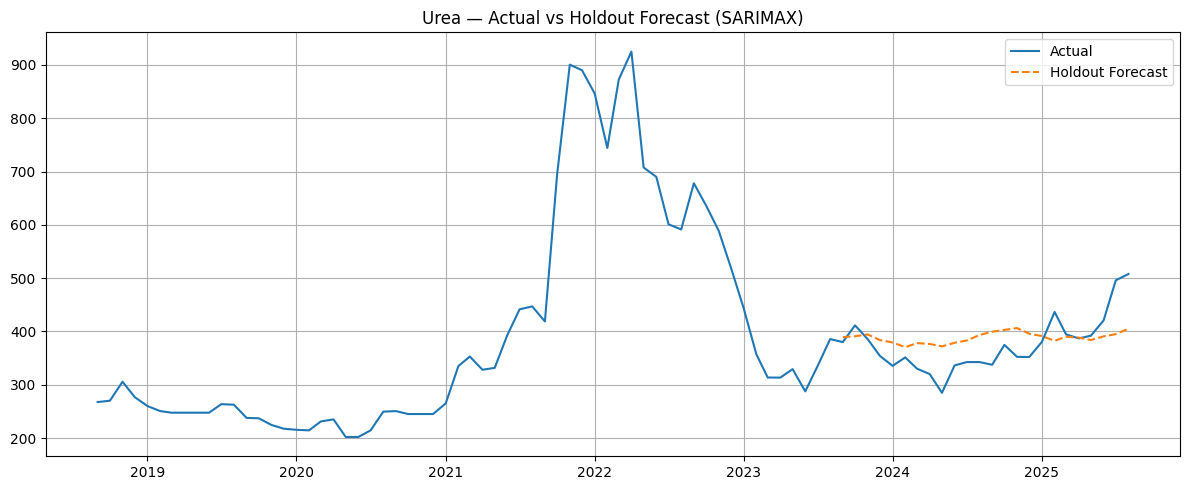

Saved plot: /content/uploads/final_package/urea_actual_vs_holdout.png


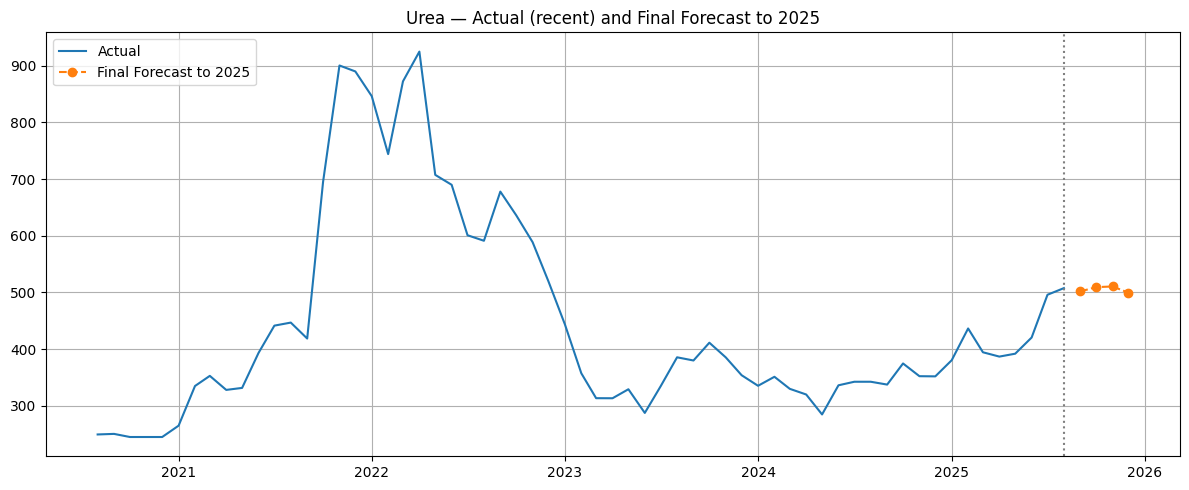

Saved plot: /content/uploads/final_package/urea_actual_plus_forecast_to2025.png
Saved metrics summary: /content/uploads/final_package/metrics_summary.txt
All outputs saved to: /content/uploads/final_package


In [14]:
# Cell 4 — final SARIMAX pipeline (runs only if combined file exists)
import pandas as pd, numpy as np
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

uploads = Path("/content/uploads")
combined_path = uploads/"combined_urea_series.csv"
out_dir = uploads/"final_package"
out_dir.mkdir(exist_ok=True)

if not combined_path.exists():
    raise SystemExit("combined_urea_series.csv not found in /content/uploads — run Cell 3 first.")

df = pd.read_csv(combined_path, parse_dates=['Date']).set_index('Date').sort_index().asfreq('MS')
series = df['Urea_monthly'].copy()
print("Series loaded:", series.index.min(), "->", series.index.max())

# user parameters (edit if needed)
START_YEAR = 2000
TRAIN_END = pd.Timestamp("2023-08-01")
HOLDOUT_START = pd.Timestamp("2023-09-01")
HOLDOUT_END = pd.Timestamp("2025-08-01")
FORECAST_END = pd.Timestamp("2025-12-01")

SARIMAX_ORDER = (0,1,2)
SARIMAX_SEASONAL = (0,1,1,12)

def mape(y_true, y_pred):
    eps = 1e-9
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

# prepare train/test
train = series.loc[f"{START_YEAR}-01-01":TRAIN_END].dropna()
test = series.loc[HOLDOUT_START:HOLDOUT_END].dropna()
print("Train rows:", len(train), "Test rows:", len(test))

# fit
print("Fitting SARIMAX ... (this may take a moment)")
mod = SARIMAX(train, order=SARIMAX_ORDER, seasonal_order=SARIMAX_SEASONAL,
              enforce_stationarity=False, enforce_invertibility=False)
res = mod.fit(disp=False, maxiter=500)
print("Fitted. AIC:", res.aic)

# holdout preds
h = len(test)
preds_hold = res.get_forecast(steps=h).predicted_mean
preds_hold.index = test.index

mae_hold = mean_absolute_error(test, preds_hold)
rmse_hold = np.sqrt(mean_squared_error(test, preds_hold))
mape_hold = mape(test.values, preds_hold.values)
print("HOLDOUT metrics -> MAE:", round(mae_hold,4), "RMSE:", round(rmse_hold,4), "MAPE:", round(mape_hold,2), "%")

# save holdout comparison
hold_df = pd.DataFrame({'Date':test.index, 'Actual':test.values, 'Forecast_SARIMAX':preds_hold.values})
hold_df.to_csv(out_dir/"sarimax_holdout_preds_2023-09_2025-08.csv", index=False)
print("Saved holdout CSV:", out_dir/"sarimax_holdout_preds_2023-09_2025-08.csv")

# refit on full observed data and forecast to FORECAST_END
last_obs = series.dropna().index.max()
y_full = series.loc[f"{START_YEAR}-01-01":last_obs].dropna()
mod_full = SARIMAX(y_full, order=SARIMAX_ORDER, seasonal_order=SARIMAX_SEASONAL,
                   enforce_stationarity=False, enforce_invertibility=False)
res_full = mod_full.fit(disp=False, maxiter=600)
print("Refit on full data. AIC:", res_full.aic)

steps = (FORECAST_END.year - last_obs.year)*12 + (FORECAST_END.month - last_obs.month)
if steps > 0:
    fc = res_full.get_forecast(steps=steps).predicted_mean
    idx = pd.date_range(start=last_obs + pd.DateOffset(months=1), periods=steps, freq='MS')
    final_fc = pd.Series(fc.values, index=idx, name='Urea_forecast')
    final_fc.reset_index().rename(columns={'index':'Date','Urea_forecast':'Urea_forecast'}).to_csv(out_dir/"urea_forecast_final_sarimax_start2000_to2025.csv", index=False)
    print("Saved final forecast CSV:", out_dir/"urea_forecast_final_sarimax_start2000_to2025.csv")
else:
    final_fc = pd.Series(dtype=float)
    print("No future forecast needed (data already up to FORECAST_END).")

# plots
plt.figure(figsize=(12,5))
plot_start = test.index.min() - pd.DateOffset(months=60)
plt.plot(series.loc[plot_start:last_obs], label='Actual')
plt.plot(preds_hold, label='Holdout Forecast', linestyle='--')
plt.title('Urea — Actual vs Holdout Forecast (SARIMAX)')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(out_dir/"urea_actual_vs_holdout.png", dpi=150)
plt.show()
print("Saved plot:", out_dir/"urea_actual_vs_holdout.png")

if not final_fc.empty:
    plt.figure(figsize=(12,5))
    plt.plot(series.loc[last_obs - pd.DateOffset(months=60): last_obs], label='Actual')
    plt.plot(final_fc, label='Final Forecast to 2025', linestyle='--', marker='o')
    plt.axvline(last_obs, color='gray', linestyle=':')
    plt.title('Urea — Actual (recent) and Final Forecast to 2025')
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_dir/"urea_actual_plus_forecast_to2025.png", dpi=150)
    plt.show()
    print("Saved plot:", out_dir/"urea_actual_plus_forecast_to2025.png")

# metrics summary
with open(out_dir/"metrics_summary.txt","w") as f:
    f.write(f"HOLDOUT MAE: {mae_hold:.4f}\nRMSE: {rmse_hold:.4f}\nMAPE: {mape_hold:.2f}%\n")
print("Saved metrics summary:", out_dir/"metrics_summary.txt")

print("All outputs saved to:", out_dir)


Columns found: ['Urea_monthly', 'Crude_Petro_monthly', 'Crude_Dubai_monthly', 'NaturalGas_US_monthly', 'Soybeans_monthly', 'Maize_monthly', 'Wheat_US_HRW_monthly']


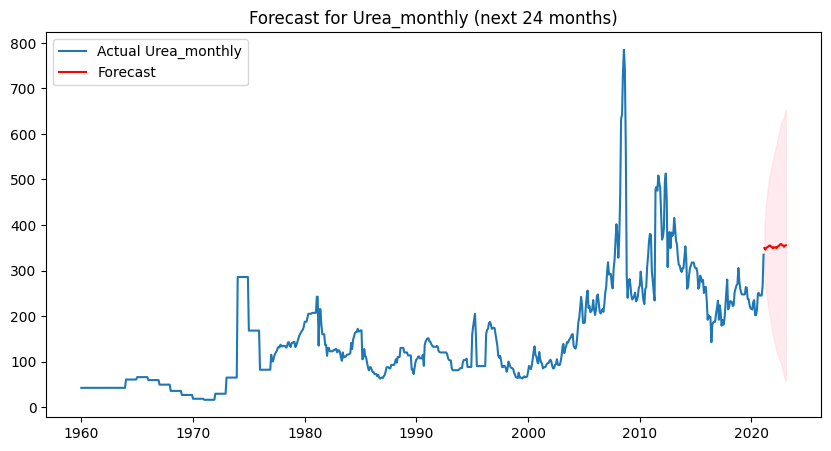

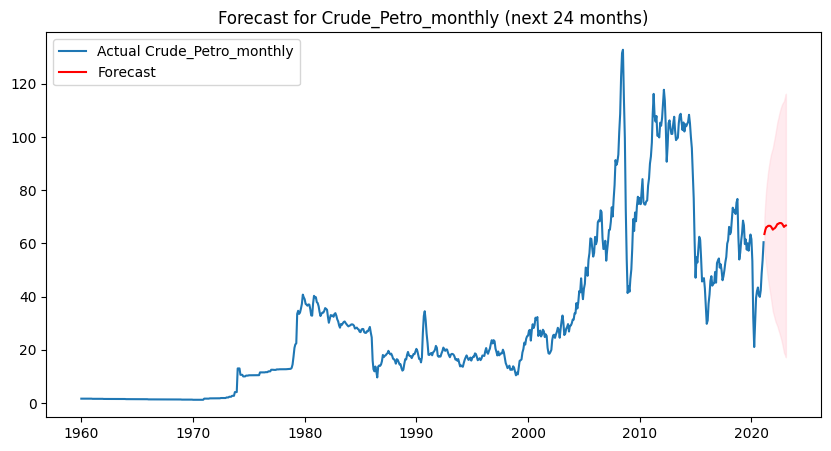

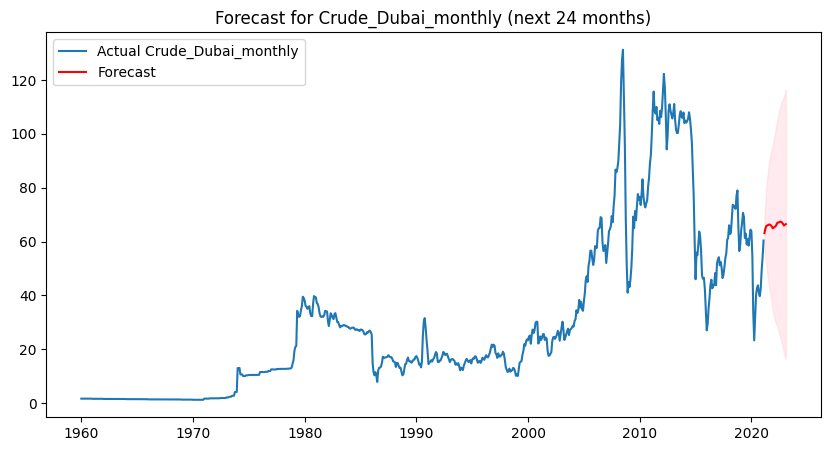

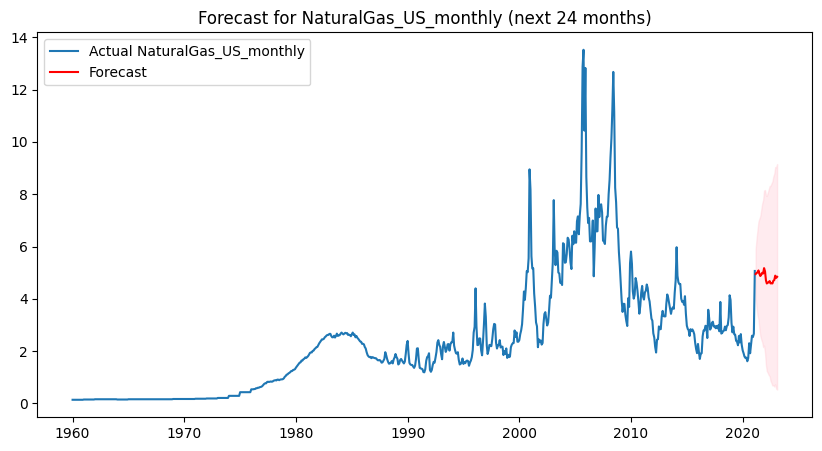

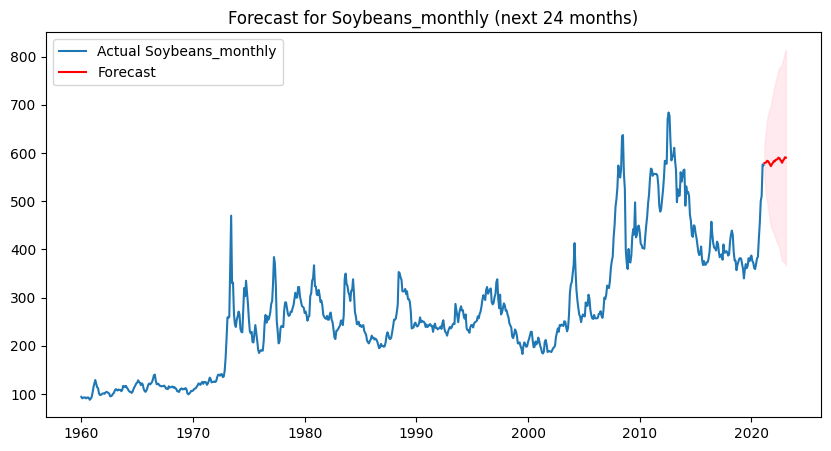

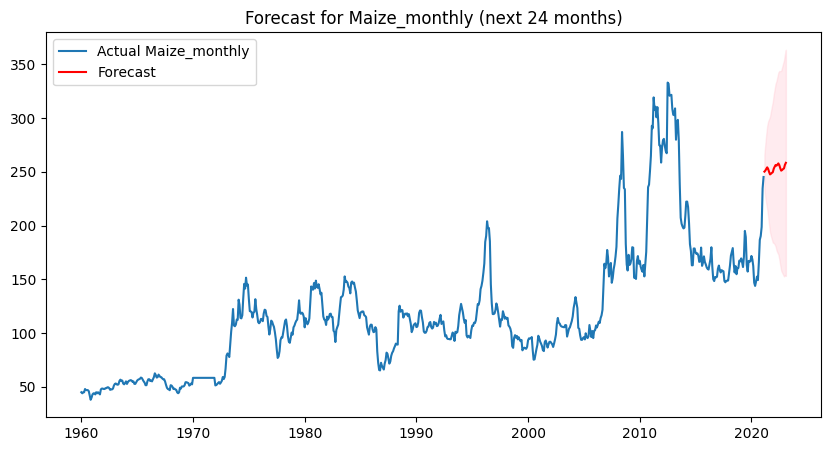

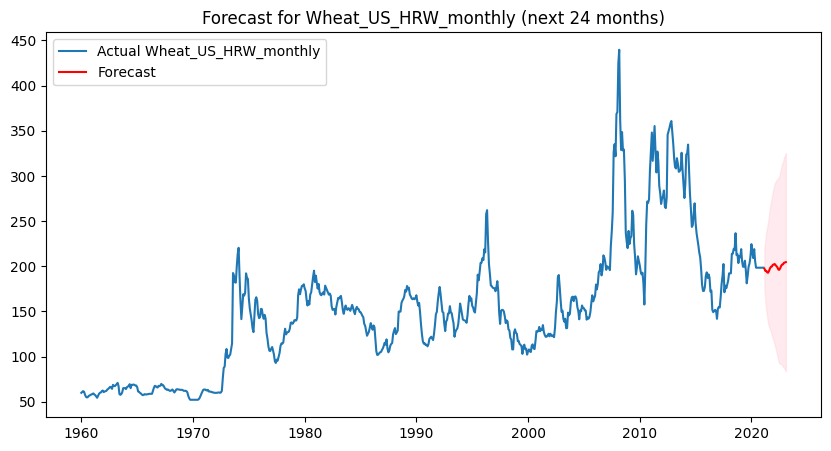


✅ Forecasts saved to /content/uploads/multi_product_forecasts.csv


In [16]:
# ---------- Multi-product Forecast with SARIMAX ----------
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ---------- Load data ----------
df = pd.read_csv("/content/uploads/merged_for_model_final.csv", parse_dates=['Date'])
df = df.set_index('Date').asfreq('MS').sort_index()

print("Columns found:", df.columns.tolist())

# محصولات (به جز ستون تاریخ)
products = [c for c in df.columns if c.lower() not in ['date']]

# ---------- Forecast loop ----------
forecast_horizon = 24   # پیش‌بینی 2 سال آینده
results = {}

for prod in products:
    series = df[prod].dropna()
    if len(series) < 50:  # حداقل دیتای کافی
        print(f"⚠️ سری {prod} خیلی کوتاهه، رد شد.")
        continue

    # مدل SARIMAX ساده
    model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12),
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)

    # پیش‌بینی
    future = res.get_forecast(steps=forecast_horizon)
    forecast = future.predicted_mean
    conf_int = future.conf_int()

    results[prod] = forecast

    # ---------- Plot ----------
    plt.figure(figsize=(10,5))
    plt.plot(series, label=f"Actual {prod}")
    plt.plot(forecast, label="Forecast", color="red")
    plt.fill_between(conf_int.index,
                     conf_int.iloc[:,0],
                     conf_int.iloc[:,1], color='pink', alpha=0.3)
    plt.title(f"Forecast for {prod} (next {forecast_horizon} months)")
    plt.legend()
    plt.show()

# ---------- Save combined forecasts ----------
forecast_df = pd.DataFrame(results)
forecast_df.to_csv("/content/uploads/multi_product_forecasts.csv")
print("\n✅ Forecasts saved to /content/uploads/multi_product_forecasts.csv")


# (اختیاری) فشرده‌سازی خروجی‌ها و دانلود مستقیم

In [ ]:
# Cell 5 — zip outputs for direct download (optional)
import shutil
archive = "/content/uploads/urea_final_package.zip"
shutil.make_archive(archive.replace(".zip",""), 'zip', "/content/uploads/final_package")
print("Archive created:", archive)

# (اختیاری) کپی خروجی‌ها به Google Drive

In [ ]:
# Cell 6 — copy outputs to Google Drive (optional)
from google.colab import drive
import shutil, os
drive.mount('/content/drive')
dst = Path("/content/drive/MyDrive/urea_forecast_project_final")
dst.mkdir(parents=True, exist_ok=True)
shutil.copytree("/content/uploads/final_package", str(dst/"final_package"), dirs_exist_ok=True)
print("Copied final_package to Drive at:", dst/"final_package")
